In [25]:
import sys
sys.path.append('/home/wangs/rs/lib')
import ff
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
sns.set_palette("pastel")
from multiprocessing import Pool
from tqdm import tqdm

In [125]:
def class_1(daily_minute_df):
    daily_minute_df['return_direction'] = np.sign(daily_minute_df['minute_return'])
    
    # 1. 不填充持平值，让其保持为0
    daily_minute_df['filled_direction'] = daily_minute_df['return_direction']
    
    # 2. 识别趋势转折点（包括持平→非持平的变化）
    daily_minute_df['trend_change'] = daily_minute_df['filled_direction'].diff().abs() > 0
    
    # 3. 为每个趋势段分配唯一ID
    daily_minute_df['trend_id'] = daily_minute_df['trend_change'].cumsum()
    
    # 4. 计算每个趋势段的最后一分钟成交量，并移到下一个趋势段
    last_volume = daily_minute_df.groupby('trend_id')['volume'].last().shift(1)
    last_volume.name = 'last_segment_volume'
    
    # 5. 将上一趋势段的最后成交量合并回原始DataFrame
    daily_minute_df = daily_minute_df.merge(
        last_volume.reset_index(), 
        on='trend_id', 
        how='left'
    )
    
    # 6. 根据当前成交量与上一趋势段最后成交量的比较，分类为放量或缩量
    daily_minute_df['class_1'] = np.where(
        daily_minute_df['volume'] > daily_minute_df['last_segment_volume'],
        '放量',
        np.where(daily_minute_df['volume'] < daily_minute_df['last_segment_volume'], '缩量', np.NaN)
    )
    
    # 7. 根据填充后的方向分类价格趋势
    daily_minute_df['price_class'] = np.where(
        daily_minute_df['filled_direction'] > 0, '上涨',
        np.where(daily_minute_df['filled_direction'] < 0, '下跌', '持平')
    )
    daily_minute_df.drop(columns=['return_direction', 'filled_direction', 'trend_change', 'last_segment_volume'], inplace=True)
    daily_minute_df['class_1'] = daily_minute_df['class_1'] + daily_minute_df['price_class']
    return daily_minute_df

In [131]:
minute_df = ff.read_min('000001.SZ')
minute_df.index.name = 'time'
minute_df.index = pd.to_datetime(minute_df.index)
datelist = minute_df.index.strftime('%Y-%m-%d').unique()
date = datelist[0]
daily_minute_df = minute_df.loc[date]
daily_minute_df['minute_return'] = daily_minute_df['close'].pct_change()
daily_minute_df.iloc[0, daily_minute_df.columns.get_loc('minute_return')] = 0
daily_minute_df = class_1(daily_minute_df)
daily_minute_df['class_2'] = daily_minute_df.groupby('trend_id').apply(class_2).reset_index(level=0, drop=True)
daily_minute_df['class_2'] = daily_minute_df['class_2'] + '持续' + daily_minute_df['price_class']
return1, return2 = daily_return_calculate(daily_minute_df)
pd.concat([return1,return2])


放量上涨      0.075118
缩量上涨      0.043849
放量下跌     -0.047625
缩量下跌     -0.054858
放量持续上涨    0.030834
平量持续上涨    0.004176
缩量持续上涨    0.007732
放量持续下跌   -0.018278
平量持续下跌   -0.006539
缩量持续下跌   -0.015950
dtype: float64

In [3]:
##第二种分类方法

def class_2(df):
    result = pd.Series(np.nan, index=df.index,name = 'class_2')
    if len(df) == 1:
        return result
    V = df['volume']
    V_min = V_max = V.iloc[0]
    for i in range(1,len(df)):
        if V.iloc[i] > V_max:
            result.iloc[i] = '放量'
            V_max = V.iloc[i]
        elif V.iloc[i] < V_min:
            result.iloc[i] = '缩量'
            V_min = V.iloc[i]
        else:
            result.iloc[i] = '平量'
    return result

In [11]:
##计算各形态的日内收益率

def daily_return_calculate(df):
    class_1_return = pd.Series(0,index = ['放量上涨','缩量上涨','放量下跌','缩量下跌'])
    class_2_return = pd.Series(0,index=  ['放量持续上涨','平量持续上涨','缩量持续上涨','放量持续下跌','平量持续下跌','缩量持续下跌'])
    for name, group in df.groupby('class_1')['minute_return']:
        if name in class_1_return.index:
            # 累乘 (1+收益率)，再减1得到总收益率
            class_1_return[name] = (group + 1).prod() - 1
    for name, group in df.groupby('class_2')['minute_return']:
        if name in class_2_return.index:
            # 累乘 (1+收益率)，再减1得到总收益率
            class_2_return[name] = (group + 1).prod() - 1      
    return class_1_return,class_2_return

In [141]:
def class_ret(stock_id):
    try:
        minute_df = ff.read_min(stock_id)
    except:
        return stock_id,pd.DataFrame(columns = ['放量上涨','缩量上涨','放量下跌','缩量下跌','放量持续上涨','平量持续上涨','缩量持续上涨','放量持续下跌','平量持续下跌','缩量持续下跌'])
    minute_df.index.name = 'time'
    minute_df.index = pd.to_datetime(minute_df.index)
    datelist = minute_df.index.strftime('%Y-%m-%d').unique()
    merge_df = pd.DataFrame(index=datelist,
                            columns = ['放量上涨','缩量上涨','放量下跌','缩量下跌','放量持续上涨','平量持续上涨','缩量持续上涨','放量持续下跌','平量持续下跌','缩量持续下跌'])


        ##计算各形态日间收益率

    for date in datelist:
        try:
            daily_minute_df = minute_df.loc[date]
            daily_minute_df['minute_return'] = daily_minute_df['close'].pct_change()
            daily_minute_df.iloc[0, daily_minute_df.columns.get_loc('minute_return')] = 0
            daily_minute_df = class_1(daily_minute_df)
            daily_minute_df['class_2'] = daily_minute_df.groupby('trend_id').apply(class_2).reset_index(level=0, drop=True)
            daily_minute_df['class_2'] = daily_minute_df['class_2'] + '持续' + daily_minute_df['price_class']

            return1, return2 = daily_return_calculate(daily_minute_df)
            merge_df.loc[date] = pd.concat([return1,return2])
        except Exception as e:
                #print(f"处理日期 {date} 时出错: {e}")
            continue
    return stock_id,merge_df

In [36]:
def ret_for_stock(max_workers = 16):
    stock_list = ff.cl
    long_table_list = []
    with Pool(processes=max_workers) as pool:
        # 使用tqdm显示进度条
        for stock_id, stock_result in tqdm(
            pool.imap_unordered(class_ret, stock_list), 
            total=len(stock_list), 
            desc="处理进度"
        ):
            if stock_result is not None:
                # 将每个股票的结果DataFrame转换为长格式
                long_df = stock_result.stack().reset_index()
                long_df.columns = ['日期', '技术形态', 'return']
                long_df['stock_id'] = stock_id
                
                # 重新排列列顺序并添加到列表
                long_table_list.append(long_df[['日期', 'stock_id', 'return', '技术形态']])
    
    # 转换为DataFrame
    if not long_table_list:''
        print("没有成功处理任何股票数据")
        return pd.DataFrame(columns=['日期', 'stock_id', 'return', '技术形态'])
    
    final_long_table = pd.concat(long_table_list, ignore_index=True)
    return final_long_table

In [142]:
stock_list = ff.cl
long_table_list = []
with Pool(96) as pool:
        # 使用tqdm显示进度条
    for stock_id, stock_result in tqdm(
        pool.imap_unordered(class_ret, stock_list), 
        total=len(stock_list), 
        desc="处理进度"
    ):
        if stock_result is not None:
                # 将每个股票的结果DataFrame转换为长格式
            long_df = stock_result.stack().reset_index()
            long_df.columns = ['日期', '技术形态', 'return']
            long_df['stock_id'] = stock_id
                
                # 重新排列列顺序并添加到列表
            long_table_list.append(long_df[['日期', 'stock_id', 'return', '技术形态']])
    

    
final_long_table = pd.concat(long_table_list, ignore_index=True)

处理进度: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5388/5388 [38:45<00:00,  2.32it/s]


In [144]:
final_long_table[final_long_table['stock_id'] == '000001.SZ'].head(20)

,日期,stock_id,return,技术形态
833850,2020-01-02,000001.SZ,0.075118,放量上涨
833851,2020-01-02,000001.SZ,0.043849,缩量上涨
833852,2020-01-02,000001.SZ,-0.047625,放量下跌
833853,2020-01-02,000001.SZ,-0.054858,缩量下跌
833854,2020-01-02,000001.SZ,0.030834,放量持续上涨
833855,2020-01-02,000001.SZ,0.004176,平量持续上涨
833856,2020-01-02,000001.SZ,0.007732,缩量持续上涨
833857,2020-01-02,000001.SZ,-0.018278,放量持续下跌
833858,2020-01-02,000001.SZ,-0.006539,平量持续下跌
833859,2020-01-02,000001.SZ,-0.01595,缩量持续下跌


In [29]:
flsz = final_long_table[final_long_table['技术形态'] == '放量上涨']

In [31]:
flsz = flsz.pivot(index = '日期',
                 columns = 'stock_id',
                 values = 'return')

In [157]:
final_long_table.to_pickle('333.pkl')

In [149]:
def factor_get(final_long_table,factor_name,N = 20):
    df = final_long_table[final_long_table['技术形态'] == factor_name]
    df = df.pivot(index = '日期',
                 columns = 'stock_id',
                 values = 'return')
    df = df.loc['2020-01-02':]
    result = pd.DataFrame(np.nan,index = df.index,columns = df.columns)
    row_means = df.mean(axis=1)  
    row_stds = df.std(axis=1) 
    df_normalized = df.sub(row_means, axis=0).div(row_stds, axis=0)
    df_abs = df_normalized.abs()
    row_means_abs = df_abs.mean(axis=1)
    row_stds_abs = df_abs.std(axis=1)
    df_abs_normalized = df_abs.sub(row_means_abs, axis=0).div(row_stds_abs, axis=0)
    for i in range(20,len(df_abs_normalized)):
        window_start = max(0,i - N)
        window = df_abs_normalized.iloc[window_start:i]
        result.iloc[i] = window.std().values
    result = result.T
    result.columns = result.columns.str.replace('-','',regex = False)
    return result

In [150]:
factor1 = factor_get(final_long_table,'放量上涨')

In [151]:
factor1

日期,20200102,20200103,20200106,20200107,20200108,20200109,20200110,20200113,20200114,20200115,...,20250625,20250626,20250627,20250630,20250701,20250702,20250703,20250704,20250707,20250708
stock_id,,,,,,,,,,,,,,,,,,,,,
000001.SZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.210519,0.213942,0.234391,0.212223,0.211531,0.205702,0.196139,0.175403,0.181202,0.187218
000002.SZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.207815,0.204822,0.204385,0.200571,0.199635,0.171911,0.170299,0.168710,0.168271,0.176943
000004.SZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.604443,0.590294,0.578080,0.576335,0.234176,0.227892,0.228312,0.220783,0.222951,0.210468
000005.SZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000006.SZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.701676,0.323837,0.315625,0.320283,0.324198,0.324685,0.308588,0.312030,0.305740,0.299234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688799.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.905696,2.956645,3.007673,2.984948,2.671486,1.805194,1.795228,1.812793,1.748111,1.498088
688800.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.280636,2.278163,2.279096,2.267450,2.256467,2.253775,2.261354,0.746037,0.747725,0.750077
688819.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.318873,0.313933,0.313472,0.303787,0.302741,0.289640,0.242298,0.217734,0.218843,0.218276


In [147]:
ff.filter0.columns = ff.filter0.columns.str.replace('-','',regex = False)
factor1.columns = factor1.columns.str.replace('-','',regex = False)

long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


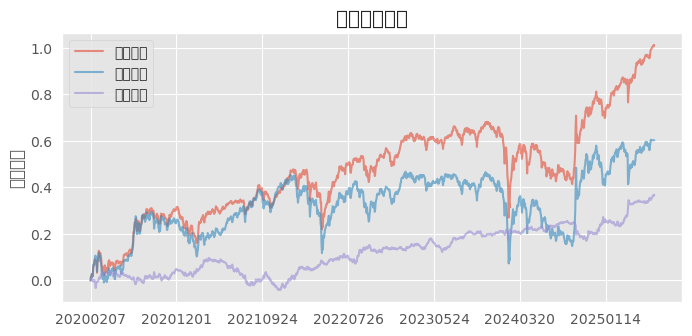

,指数收益,超额收益,策略收益
年化收益率,0.115,0.070,0.193
年化波动率,0.244,0.080,0.224
夏普率,0.471,0.878,0.862
最大回撤,-0.395,-0.138,-0.412
收益回撤比,0.291,0.508,0.468
胜率,0.536,0.493,0.560
盈亏比,0.942,1.197,0.922


In [156]:
result = ff.run(factor1 * ff.filter0, positions=100, period=1, fees=0)